In [21]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklego.linear_model import LowessRegression
import os
import re

### Reading in from external source

In [22]:
geo = "GSE114711"
geo_data = GEOparse.get_GEO(geo=geo, destdir="../Dataset/Nigita2018", silent=True)
#table = pd.read_csv("../Dataset/Fehlman2020/expression_matrix.csv", sep="\t")
#table = pd.read_csv("../Dataset/Wozniak2015/GSE64591_non-normalized.txt", sep="\t", header=5)

In [23]:
list(geo_data.gsms.values())[-1].metadata

{'title': ['LATE STAGE rep8'],
 'geo_accession': ['GSM3148019'],
 'status': ['Public on Jun 29 2018'],
 'submission_date': ['May 21 2018'],
 'last_update_date': ['Jun 29 2018'],
 'type': ['SRA'],
 'channel_count': ['1'],
 'source_name_ch1': ['Plasma-derived exosome'],
 'organism_ch1': ['Homo sapiens'],
 'taxid_ch1': ['9606'],
 'characteristics_ch1': ['dissease state: late stage NSCLC',
  'Stage: IV',
  'Sex: Female',
  'sample type: PEV'],
 'growth_protocol_ch1': ['PEVs were isolated using the Izon qEV size exclusion column (Izon qEV, iZON science, Cambridge MA). 190uL of plasma (centrifuged for 10 minutes at 10,000xG) was added to the column membrane, followed by 310uL of PBS.  PBS was then added in 500uL increments for a total of 32 fractions. The fractions were run on a NuPAGE Bis-Tris gel to evaluate protein contamination.  Fractions 7-9 were combined as the EV fraction and fractions 12-32 were combined as the depleted fraction.  Both the EV and depleted fractions were concentrated

In [24]:
data = pd.read_csv("../Dataset/Nigita2018/Cases/GSM3147994_C1.txt", sep="\t", names=["miRNA", "value"])
data

,miRNA,value
0,hsa-let-7a-1,0
1,hsa-let-7a-1*,0
2,hsa-let-7a-2,0
3,hsa-let-7a-2*,0
4,hsa-let-7a-3,0
...,...,...
3757,hsa-mir-98*,0
3758,hsa-mir-99a,0
3759,hsa-mir-99a*,0
3760,hsa-mir-99b,5


In [25]:
cases = []
controls = []
for d in os.listdir("../Dataset/Nigita2018/Cases/"):
    pat = "[0-9]+.txt$"
    if re.search("E" + pat, d) or re.search("L" + pat, d):
        cases.append(pd.read_csv("../Dataset/Nigita2018/Cases/" + d, sep="\t", names=["miRNA", "value"]))
    if re.search("C" + pat, d):
        controls.append(pd.read_csv("../Dataset/Nigita2018/Cases/" + d, sep="\t", names=["miRNA", "value"]))

In [26]:
table = pd.concat([c.iloc[:,1] for c in controls] + [c.iloc[:,1] for c in cases], axis=1).transpose()
mirnas = cases[0].iloc[:,0]

### Seperate case and controls

In [27]:
controls = np.array(len(controls)*[1] + len(cases)*[0])
sick = 1 - controls

In [28]:
sum(controls)

7

### Drop NAN

In [29]:
mask = table.std() != 0
table = table.loc[:, mask]
mirnas = mirnas[mask]

In [30]:
table.isna().sum().sum()

0

In [31]:
table = table.dropna(1)

C:\Users\olefr\AppData\Local\Temp/ipykernel_20012/1927661217.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  table = table.dropna(1)


### T-test

In [32]:
X = table

In [33]:
X_healthy, X_cancer = X[controls == 1], X[sick == 1]

In [34]:
results = ttest_ind(X_healthy, X_cancer).pvalue

In [35]:
lowest, pvalues = np.argsort(results)[:5], np.sort(results)[:5]

In [36]:
mirnas.iloc[lowest], pvalues

(52       hsa-mir-10b
 3050     hsa-mir-668
 538     hsa-mir-200a
 374      hsa-mir-141
 2924     hsa-mir-629
 Name: miRNA, dtype: object,
 array([0.00235666, 0.00516554, 0.00644583, 0.01021402, 0.01519632]))

### F-test

In [37]:
t3 = table

In [38]:
f, p = f_classif(t3, sick)

In [39]:
np.mean(p)

0.4922212699421608

### ANOVA

In [40]:
t3

,2,6,8,10,12,14,16,18,20,24,...,3720,3722,3726,3732,3746,3748,3750,3756,3758,3760
value,0,8,0,76,4,0,0,3,39,0,...,0,7,0,5,0,0,0,0,0,5
value,0,18,0,64,0,0,3,5,29,0,...,0,4,0,6,0,0,5,0,2,4
value,0,4,0,140,3,0,0,4,54,0,...,0,0,0,5,0,0,9,0,7,0
value,0,0,0,29,2,0,0,3,10,0,...,0,1,0,0,0,0,8,0,0,13
value,0,35,0,299,1,0,1,5,62,1,...,0,5,0,8,1,0,13,2,1,6
value,0,12,0,75,11,0,0,0,4,0,...,0,2,0,0,0,0,20,0,7,16
value,1,6,0,55,3,5,0,0,4,0,...,0,17,0,0,0,0,6,0,0,9
value,0,0,0,33,0,0,0,0,2,0,...,0,5,0,0,0,0,2,0,0,6
value,0,6,0,77,0,2,0,4,23,0,...,0,20,0,0,0,0,0,0,0,4
value,0,43,0,156,0,0,0,26,41,0,...,0,26,0,13,0,0,0,0,0,12


In [41]:
X = np.array(sick).reshape(-1, 1)

In [42]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [43]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted, multioutput="variance_weighted")

0.02278929118198032

### Mean-variance-plot

In [44]:
np.mean(table)

2        0.153846
6        9.461538
8        0.115385
10      90.423077
12       1.884615
          ...    
3748     0.115385
3750     5.384615
3756     0.115385
3758     1.923077
3760     8.346154
Length: 460, dtype: float64

In [45]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [46]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

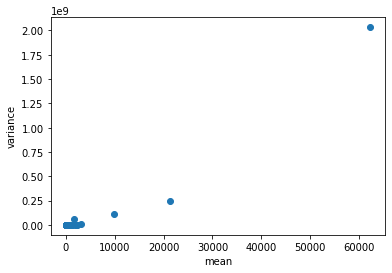

In [47]:
mean_variance_plot(table)

### Log transformation

In [48]:
log_table = table #np.log2(table + 1)

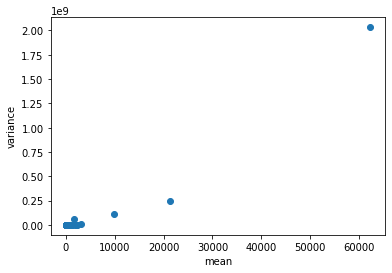

In [49]:
mean_variance_plot(log_table)

### Loess regression

In [50]:
lowess = LowessRegression(sigma=1, span=0.1)

In [51]:
means, variances = get_means_and_variances(log_table)
lowess.fit(means.to_numpy().reshape(-1,1), variances)

LowessRegression(span=0.1)

In [52]:
x_axis = np.linspace(-2, 14, 100)
y_axis = lowess.predict(x_axis.reshape(-1,1))

[]

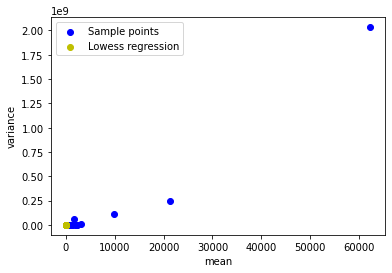

In [53]:
plt.scatter(means, variances, color="b")
plt.scatter(x_axis, y_axis, color="y")
plt.xlabel("mean")
plt.ylabel("variance")
plt.legend(["Sample points", "Lowess regression"])
plt.plot()

### Lowess normalization

In [54]:
norm_log_table = log_table #- np.mean(log_table)
#norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

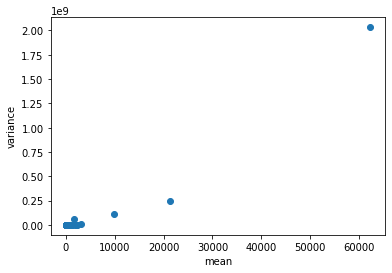

In [55]:
mean_variance_plot(norm_log_table)

### PCA

In [56]:
pca = decomposition.PCA(n_components=10)

In [57]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [58]:
pca.explained_variance_ratio_

array([9.08675040e-01, 4.80378676e-02, 2.45297318e-02, 1.77835360e-02,
       4.17530069e-04, 2.51850397e-04, 1.48441416e-04, 5.90431440e-05,
       3.85728225e-05, 1.66322720e-05])

In [59]:
components = pca.transform(norm_log_table)

In [60]:
components.shape

(26, 10)

In [61]:
sum(controls)

7

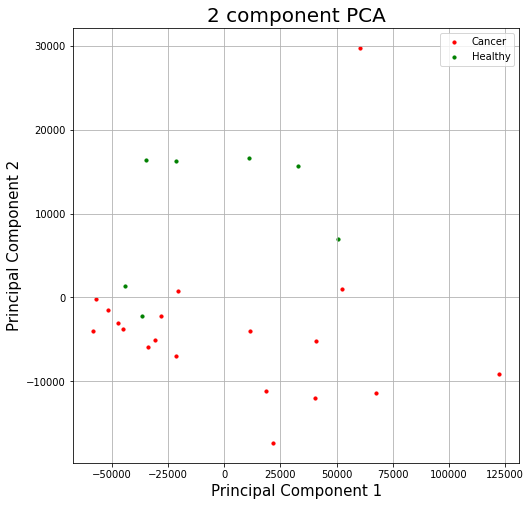

In [62]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [63]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

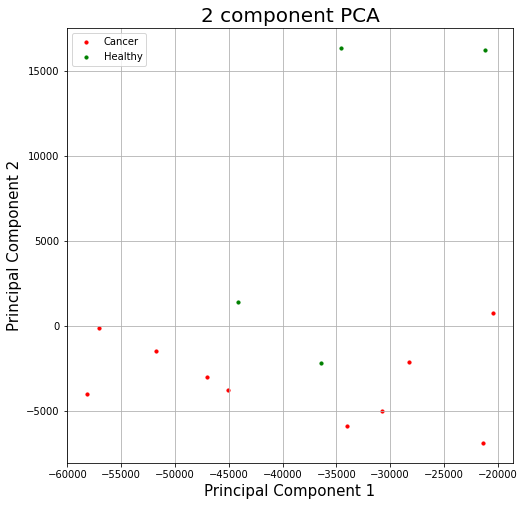

In [64]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Linear regression adjustments

In [65]:
sex = np.array(["Female" in k.metadata["characteristics_ch1"][2] for k in list(geo_data.gsms.values())])

In [66]:
sex

array([ True,  True, False, False, False,  True, False,  True,  True,
       False,  True,  True,  True, False,  True, False,  True, False,
        True,  True,  True,  True,  True, False, False,  True])

In [67]:
covars = pd.DataFrame(np.array([sex]).transpose(), columns=["sex"])

In [68]:
covars = covars.fillna(covars.mean())

In [69]:
linreg = LinearRegression()
linreg.fit(covars, norm_log_table)

LinearRegression()

In [70]:
adj_norm_log_table = norm_log_table #- linreg.predict(covars)

# PCA

In [71]:
pca = decomposition.PCA(n_components=2)

In [72]:
pca.fit(adj_norm_log_table)

PCA(n_components=2)

In [73]:
components = pca.transform(adj_norm_log_table)

In [74]:
components

array([[-36379.72130927,  -2209.99135059],
       [-21190.70494438,  16217.5062736 ],
       [ 11158.78093097,  16629.4079154 ],
       [-44185.77853349,   1402.32339323],
       [ 50718.87733864,   6975.86920797],
       [ 32925.71030417,  15623.47351755],
       [-34588.66397072,  16373.11661906],
       [-58185.09739165,  -4021.00986743],
       [ 40369.67943164, -11985.0975882 ],
       [ 60318.49097076,  29743.0250413 ],
       [-21342.004995  ,  -6916.17226489],
       [ 40872.59350807,  -5132.058481  ],
       [ 11630.13358338,  -4031.05056671],
       [-45071.8692235 ,  -3763.04566381],
       [-30770.64795007,  -5023.00127767],
       [ 67361.2376793 , -11324.85132893],
       [122229.53634188,  -9049.99938004],
       [ 52347.09011619,    983.44473563],
       [-51748.89159029,  -1521.25195201],
       [ 21557.21131365, -17328.23766686],
       [-57061.77444652,   -151.62309835],
       [-47000.49886163,  -3037.74792952],
       [-33995.96697819,  -5941.65062   ],
       [-20

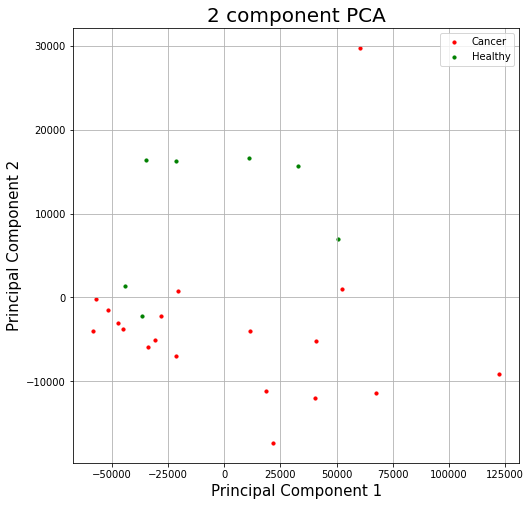

In [75]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [76]:
X_train, X_test, y_train, y_test = train_test_split(adj_norm_log_table, controls, test_size=0.33, random_state=42)

In [77]:
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


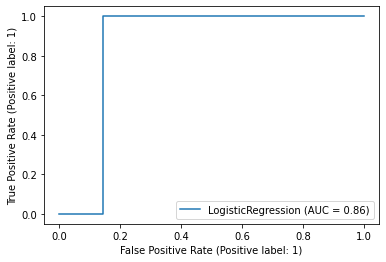

In [78]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [79]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[19:19:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


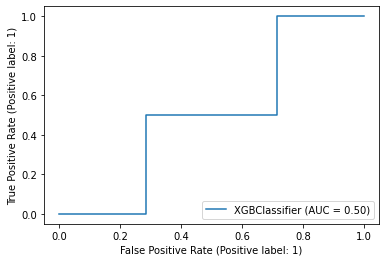

In [80]:
plot_roc_curve(model, X_test, y_test)

### Export data

In [81]:
geo_data.gpls["GPL18573"].table

""


In [82]:
mirnas = [m.replace("r", "R") for m in mirnas]

In [83]:
from Scripts import converters

In [84]:
sequences = converters.canonical_to_seq(mirnas, True)

In [85]:
sequences.count(None)

98

In [86]:
sequences = np.array(sequences)
mirnas = np.array(mirnas)

In [87]:
mask = sequences != None
adj_norm_log_table = adj_norm_log_table.loc[:, mask]
sequences = sequences[mask]

In [88]:
adj_norm_log_table.columns = sequences
adj_norm_log_table["cancer"] = sick
adj_norm_log_table.head()

C:\Users\olefr\AppData\Local\Temp/ipykernel_20012/1925367317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_norm_log_table["cancer"] = sick


,AGGUUGAGGUAGUAGGUUGUAUAGUUUAGAAUUACAUCAAGGGAGAUAACUGUACAGCCUCCUAGCUUUCCU,CGGGGUGAGGUAGUAGGUUGUGUGGUUUCAGGGCAGUGAUGUUGCCCCUCGGAAGAUAACUAUACAACCUACUGCCUUCCCUG,GCAUCCGGGUUGAGGUAGUAGGUUGUAUGGUUUAGAGUUACACCCUGGGAGUUAACUGUACAACCUUCUAGCUUUCCUUGGAGC,CCUAGGAAGAGGUAGUAGGUUGCAUAGUUUUAGGGCAGGGAUUUUGCCCACAAGGAGGUAACUAUACGACCUGCUGCCUUUCUUAGG,CCCGGGCUGAGGUAGGAGGUUGUAUAGUUGAGGAGGACACCCAAGGAGAUCACUAUACGGCCUCCUAGCUUUCCCCAGG,UCAGAGUGAGGUAGUAGAUUGUAUAGUUGUGGGGUAGUGAUUUUACCCUGUUCAGGAGAUAACUAUACAAUCUAUUGCCUUCCCUGA,UGUGGGAUGAGGUAGUAGAUUGUAUAGUUUUAGGGUCAUACCCCAUCUUGGAGAUAACUAUACAGUCUACUGUCUUUCCCACG,AGGCUGAGGUAGUAGUUUGUACAGUUUGAGGGUCUAUGAUACCACCCGGUACAGGAGAUAACUGUACAGGCCACUGCCUUGCCA,CUGGCUGAGGUAGUAGUUUGUGCUGUUGGUCGGGUUGUGACAUUGCCCGCUGUGGAGAUAACUGCGCAAGCUACUGCCUUGCUA,AAAAGUGCUUACAGUGCAGGUAG,...,CCAGUUACCGCUUCCGCUACCGC,AUCCGCGCUCUGACUCUCUGCC,AAGGCAGGGCCCCCGCUCCCC,CUGACUGUUGCCGUCCUCCAG,AAAUUAUUGUACAUCGGAUGAG,UUCAACGGGUAUUUAUUGAGCA,UGAGGUAGUAAGUUGUAUUGUU,AACCCGUAGAUCCGAUCUUGUG,CACCCGUAGAACCGACCUUGCG,cancer
value,0,8,0,76,4,0,0,3,39,0,...,7,0,5,0,0,0,0,0,5,0
value,0,18,0,64,0,0,3,5,29,0,...,4,0,6,0,0,5,0,2,4,0
value,0,4,0,140,3,0,0,4,54,0,...,0,0,5,0,0,9,0,7,0,0
value,0,0,0,29,2,0,0,3,10,0,...,1,0,0,0,0,8,0,0,13,0
value,0,35,0,299,1,0,1,5,62,0,...,5,0,8,1,0,13,2,1,6,0


In [89]:
adj_norm_log_table.to_csv("../TransformedData/Nigita2018_raw.csv", index=False)